<br>

## 1. Data loading & preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import model_selection

In [3]:
train= pd.read_csv('train4.csv')

#train4.csv 결측치행, index 열 제거
train.dropna(inplace=True)
train.drop(['Unnamed: 0'], axis=1, inplace=True)

# 성별 분류
train['gender'] = train['gender'].replace(['F','M'],[0,1])

# 차량 소유 분류
train['car'] = train['car'].replace(['N','Y'],[0,1])

# 부동산(주택) 소유 분류
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
train['family_type'] = train['family_type'].replace(['Married','Civil marriage','Single / not married','Separated','Widow'],[1,1,0,0,0])

train.loc[train['family_size'] >= 5,'family_size']=5
train.loc[train['child_num'] >= 3,'child_num']=3

train['age'] = train['DAYS_BIRTH']*(-1)/365
train['age'] = train['age'].round(0)

# train['begin_month'] = train['begin_month']* -1
# train.loc[train['DAYS_EMPLOYED'] >0,'DAYS_EMPLOYED']=0
# train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED']* -1
train.drop('DAYS_BIRTH',axis=1,inplace=True)

train['age']= -train['age']
# test['age']= -test['age']
train['income_total'] = train['income_total']/10000 

train["child_num"]=train["child_num"].apply(lambda x: 1 if x!=0 else 0 )
#del train["child_num"]

train_target = train[['credit']].copy()
train_data = train.drop('credit',axis=1).copy()


train_data, test_data, train_label, test_label = model_selection.train_test_split(train_data, 
                                                                    train_target, 
                                                                    test_size=0.3, 
                                                                    random_state=0)

<br>

## 2. Change normal labels to one-hot labels

In [4]:
train_label[:5]

,credit
2703,1.0
23360,0.0
3586,0.0
15917,2.0
8462,2.0


In [5]:
from tensorflow.keras import utils

train_label = utils.to_categorical(train_label) # 0 or 1 -> one-hot vector
test_label = utils.to_categorical(test_label) # 0 or 1 -> one-hot vector

print(train_label.shape) 
print(test_label.shape)



(17376, 3)
(7447, 3)


## 3. pipeline 적용

In [7]:
numeric_features = ['income_total',"DAYS_EMPLOYED","family_size","begin_month","age"]
numeric_transformer = StandardScaler()

categorical_features = ['gender', 'car', 'reality',"child_num",'income_type', 'edu_type', 'family_type',"house_type","work_phone","phone","email","occyp_type"]
categorical_transformer = OneHotEncoder(categories='auto') # categories='auto' : just for ignoring warning messages

preprocessor = ColumnTransformer(
    transformers=[ # List of (name, transformer, column(s))
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [8]:
preprocessor_pipe = Pipeline(steps=[('preprocessor', preprocessor)])
preprocessor_pipe.fit(train_data)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['income_total',
                                                   'DAYS_EMPLOYED',
                                                   'family_size', 'begin_month',
                                                   'age']),
                                                 ('cat', OneHotEncoder(),
                                                  ['gender', 'car', 'reality',
                                                   'child_num', 'income_type',
                                                   'edu_type', 'family_type',
                                                   'house_type', 'work_phone',
                                                   'phone', 'email',
                                                   'occyp_type'])]))])

In [9]:
x_train_transformed = preprocessor_pipe.transform(train_data)
x_test_transformed = preprocessor_pipe.transform(test_data)

In [10]:
x_train_transformed.shape

(17376, 55)

## 4. Build & Train the model 

In [12]:
import tensorflow as tf

from tensorflow.keras import datasets, utils
from tensorflow.keras import models, layers, activations, initializers, losses, optimizers, metrics

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [14]:
model = models.Sequential() 

model.add(layers.Dense(input_dim=55, units=256, activation=None, kernel_initializer=initializers.he_uniform())) # he-uniform initialization
model.add(layers.BatchNormalization())
model.add(layers.Activation('elu')) 

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 

model.add(layers.Dense(units=512, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu'))

model.add(layers.Dense(units=256, activation=None, kernel_initializer=initializers.he_uniform())) 
model.add(layers.Activation('elu')) 
model.add(layers.Dropout(rate=0.5)) 

model.add(layers.Dense(units=3, activation='softmax')) 

In [15]:
model.compile(optimizer=optimizers.Adam(), 
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy]) 

In [16]:
history = model.fit(x_train_transformed, train_label, batch_size=100, epochs=20, validation_split=0.3) 

Epoch 1/20
122/122 [==============================] - 6s 35ms/step - loss: 1.2680 - categorical_accuracy: 0.5411 - val_loss: 0.8958 - val_categorical_accuracy: 0.6455
Epoch 2/20
122/122 [==============================] - 4s 29ms/step - loss: 0.9785 - categorical_accuracy: 0.5994 - val_loss: 0.8802 - val_categorical_accuracy: 0.6440
Epoch 3/20
122/122 [==============================] - 4s 29ms/step - loss: 0.9150 - categorical_accuracy: 0.6267 - val_loss: 0.8521 - val_categorical_accuracy: 0.6610
Epoch 4/20
122/122 [==============================] - 4s 29ms/step - loss: 0.8767 - categorical_accuracy: 0.6424 - val_loss: 0.8491 - val_categorical_accuracy: 0.6633
Epoch 5/20
122/122 [==============================] - 3s 26ms/step - loss: 0.8607 - categorical_accuracy: 0.6504 - val_loss: 0.8484 - val_categorical_accuracy: 0.6645
Epoch 6/20
122/122 [==============================] - 4s 31ms/step - loss: 0.8517 - categorical_accuracy: 0.6556 - val_loss: 0.8490 - val_categorical_accuracy: 0.657

In [17]:
result = model.evaluate(x_test_transformed, test_label)

print('loss (cross-entropy) :', result[0])
print('test accuracy :', result[1])

233/233 [==============================] - 1s 5ms/step - loss: 0.8660 - categorical_accuracy: 0.6557
loss (cross-entropy) : 0.8659916520118713
test accuracy : 0.6557002663612366


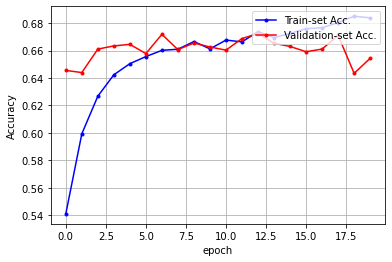

In [18]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

x_len = np.arange(len(acc))

plt.plot(x_len, acc, marker='.', c='blue', label="Train-set Acc.")
plt.plot(x_len, val_acc, marker='.', c='red', label="Validation-set Acc.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

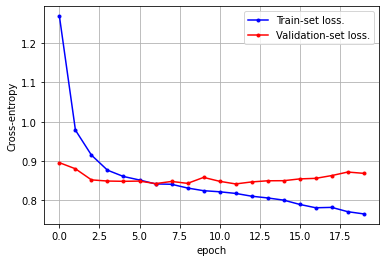

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

x_len = np.arange(len(acc))

plt.plot(x_len, loss, marker='.', c='blue', label="Train-set loss.")
plt.plot(x_len, val_loss, marker='.', c='red', label="Validation-set loss.")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Cross-entropy')
plt.show()

In [20]:
model.predict(x_test_transformed)

array([[0.09584611, 0.16195647, 0.74219745],
       [0.11007542, 0.13442065, 0.75550395],
       [0.06411966, 0.10281219, 0.83306813],
       ...,
       [0.07079752, 0.2175725 , 0.71163005],
       [0.05496232, 0.19307217, 0.75196546],
       [0.04181145, 0.13663617, 0.82155234]], dtype=float32)

In [21]:
result=np.argmax(model.predict(x_test_transformed), axis=1)